In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify

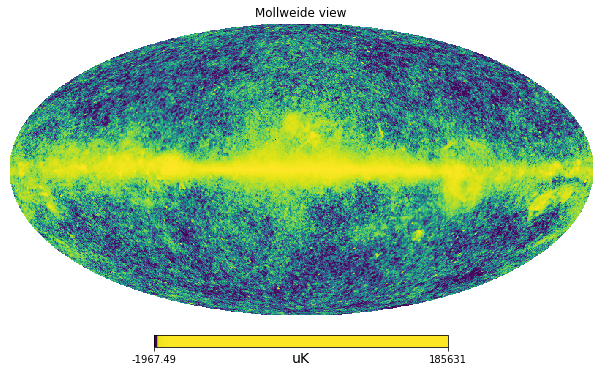

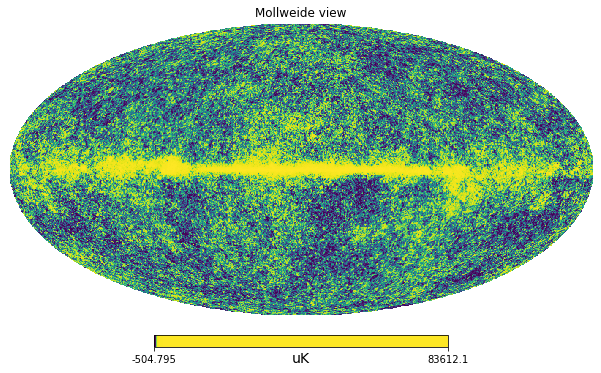

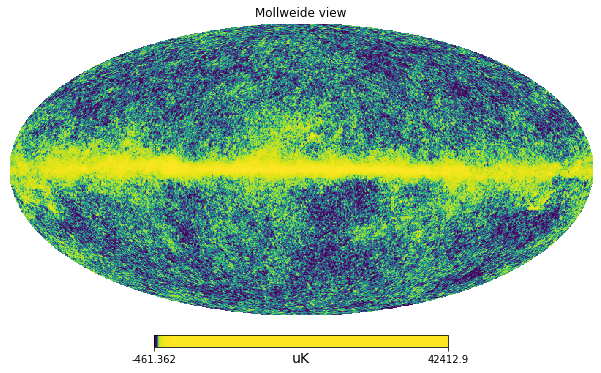

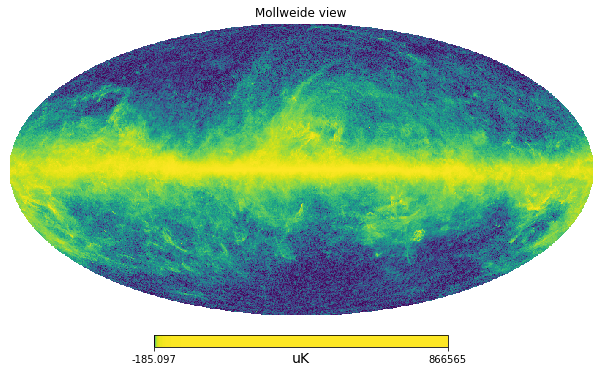

In [2]:
CMB_30_p  = hp.read_map("LFI_SkyMap_030-field-IQU_1024_R3.00_full.fits", dtype=None, verbose=False)
CMB_70_p  = hp.read_map("LFI_SkyMap_070-field-IQU_1024_R3.00_full.fits", dtype=None, verbose=False)
CMB_143_p = hp.read_map("HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits", dtype=None, verbose=True)
CMB_353_p = hp.read_map("HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits", dtype=None, verbose=False)

hp.mollview((CMB_30_p * 10**6), unit='uK', norm='hist')
hp.mollview((CMB_70_p * 10**6), unit='uK', norm='hist')
hp.mollview((CMB_143_p * 10**6), unit='uK', norm='hist')
hp.mollview((CMB_353_p * 10**6) , unit='uK', norm='hist')

def rescale(map, NSIDE):
    
    rescaled = hp.ud_grade(map, NSIDE)
    
    return rescaled

NSIDE = 2048  # LFI are 1024, HFI are 2048, scale all to 1024
LMAX  = 2048

CMB_30_p  = rescale(CMB_30_p, NSIDE)
CMB_70_p  = rescale(CMB_70_p, NSIDE)
CMB_143_p = rescale(CMB_143_p, NSIDE)
CMB_353_p = rescale(CMB_353_p, NSIDE)

In [3]:
def harmonic(pmap, LMAX):
    # step 1 - convert maps to harmonic space, i.e the form s(ℓ,m).
    
    hmap = hp.map2alm(pmap, lmax=LMAX)
    
    return hmap

In [4]:
def cov_inv(hmaps):
    # step 2 - calculate their C and inverse matrix
    
    maps_stack = np.stack(hmaps)
    
    
    # C is the covariance matrix of the observations in mode (ℓ,m)
    # but covariance is the sum of all modes where l != 0
    #
    # Healpix stores lm data ordered by m
    # I.e. if ℓmax is 16, the first 16 elements are m=0,ℓ=0−16, then the following 15 elements are m=1,ℓ=1−16,
    # then m=2,ℓ=2−16 and so on until the last element, the 153th, is m=16,ℓ=16.
    #
    # only m=0, l=0 to be discarded, the first value of each row
    
    stack_cut = np.delete(maps_stack, obj=0, axis=1)
    
    C_lm = np.cov(stack_cut)
    C_inv = np.linalg.inv(C_lm)
    # diagnostics
    
    #print("stack", np.shape(maps_stack))
    #print("stack_cut", np.shape(stack_cut))
    #print("C_lm", np.shape(C_lm))
    #print("C_inv", np.shape(C_inv))
    
    return C_inv

### $$ w_i = \frac{\sum\limits_j [C]^{-1}_{ij}}{\sum\limits_i \sum\limits_j [C]^{-1}_{ij}} $$

In [5]:
def weight_gen(C_inv):
    # step 3 - calculate the weights
    
    # not sure how to code the sum, must check that weights equal 1
        
    # numerator:
    # ∑_j [C−1]_ij
    
    numerator = np.sum(C_inv, axis=0)  
    
    # denominator: 
    # ∑_i ∑_j [C−1]_ij       is this the same as ∑_i [numerator] ?
    
    denominator = np.sum(numerator) 
    
    w = numerator / denominator

    
    #check the weight requirement:
    
    w_tot = np.sum(w)
    
    print("The total weight is:",w_tot,)
    
    if w_tot == 1:
        print("Weights calculated successfuly")
    elif w_tot.imag < (10**10):
        print("Small weighting error, probably negligible")
        # sometimes produces imag weights in the 10**-19 or -20 range, these are probably fine
    else:
        print("There is an error in weight calculation")
        
    return w

In [6]:
CMB_30_h  = harmonic(CMB_30_p, LMAX)
CMB_70_h  = harmonic(CMB_70_p, LMAX)
CMB_143_h = harmonic(CMB_143_p, LMAX)
CMB_353_h = harmonic(CMB_353_p, LMAX)

alm_set = (CMB_30_h, CMB_70_h, CMB_143_h, CMB_353_h)

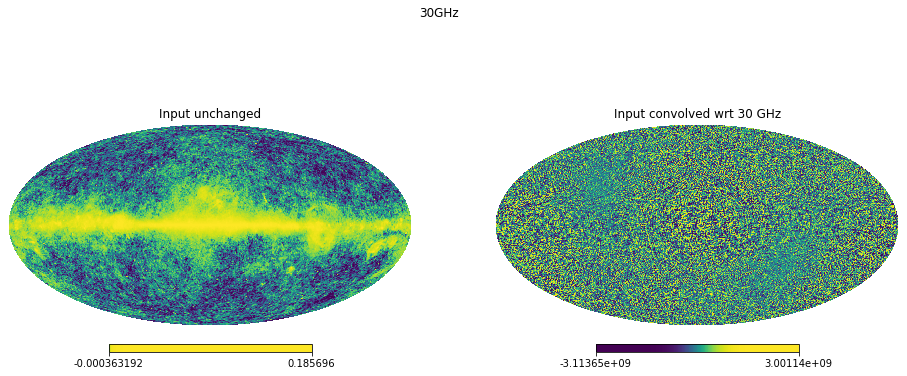

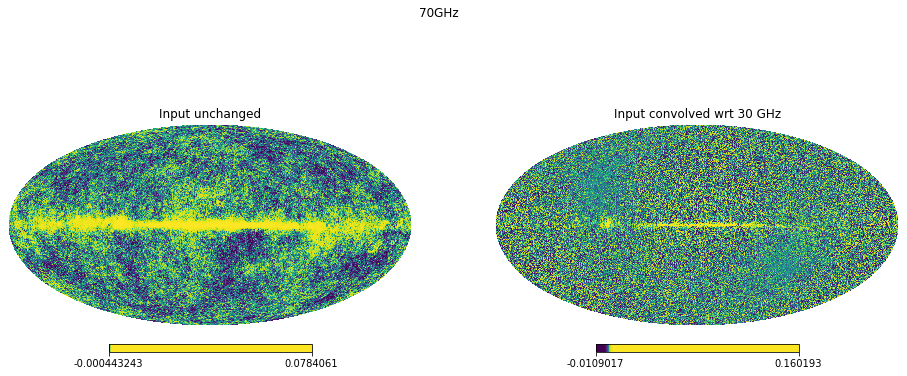

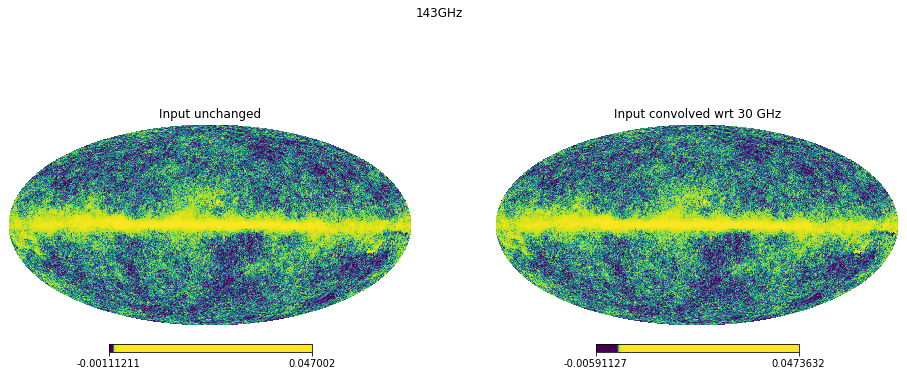

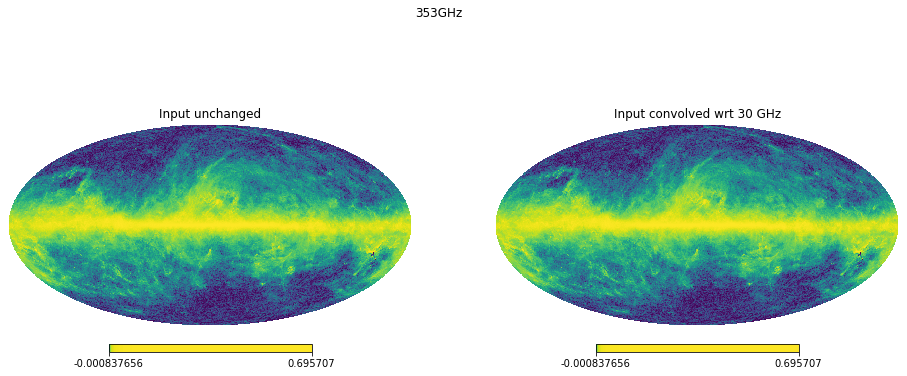

In [7]:
# 2 - generate Beam functions for each alm
test_val = 0

FWHM_name_set = ["30GHz","70GHz","143GHz","353GHz"]
FWHM_arc = (32.239, 13.252, 7.248, 4.818)                # arcmin
FWHM_set = [i * (np.pi / (60*180)) for i in FWHM_arc]    # radians

beam_set  = []
for i in range(len(FWHM_set)):
    beam = hp.gauss_beam(fwhm=FWHM_set[i], lmax=LMAX, pol=False)
    beam_set.append(beam)
    
beam_mods = []
for i in range(len(FWHM_set)):
    beam_mod = beam_set[-1]/beam_set[i]
    beam_mods.append(beam_mod)

    
alm_modified_set = np.zeros(np.shape(alm_set), dtype=complex)

for i in range(len(FWHM_set)):
    alm_modified_set[i] = hp.almxfl(alm_set[i], beam_mods[i])
    
# viewing the effect of convolving each map:

for i in range(len(FWHM_set)):
    
    a = hp.alm2map(alm_set[i], nside=NSIDE, lmax=LMAX, verbose=False)           # original map
    b = hp.alm2map(alm_modified_set[i], nside=NSIDE, lmax=LMAX, verbose=False)  # convolved map
    
    fig = plt.figure(figsize=(16,6))
    plt.suptitle(FWHM_name_set[i])

    plt.subplot(1,2,1)
    hp.mollview(a, norm='hist', title='Input unchanged', hold=True)

    plt.subplot(1,2,2)
    hp.mollview(b, norm='hist', title='Input convolved wrt 30 GHz', hold=True)   
        
alm_set = alm_modified_set

CMB_30_p  = hp.alm2map(alm_modified_set[0], nside=NSIDE, lmax=LMAX, verbose=False)
CMB_70_p  = hp.alm2map(alm_modified_set[1], nside=NSIDE, lmax=LMAX, verbose=False)
CMB_143_p = hp.alm2map(alm_modified_set[2], nside=NSIDE, lmax=LMAX, verbose=False)
CMB_353_p = hp.alm2map(alm_modified_set[3], nside=NSIDE, lmax=LMAX, verbose=False)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


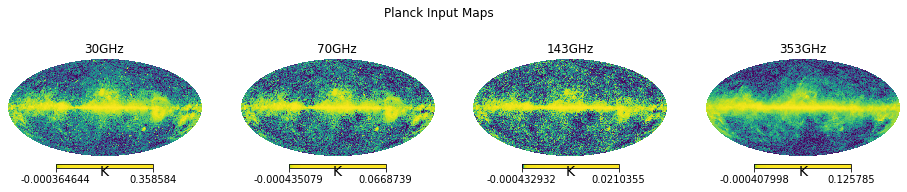

In [46]:
synthetic = 1

if synthetic==1:
    CMB_30_p  = hp.read_map("synthetic_30GHz_m.fits", dtype=None, verbose=False) * (1 - np.random.normal(0, .05, CMB_30_p.shape))
    CMB_70_p  = hp.read_map("synthetic_70GHz_m.fits", dtype=None, verbose=False) * (1 - np.random.normal(0, .05, CMB_30_p.shape))
    CMB_143_p = hp.read_map("synthetic_143GHz_m.fits", dtype=None, verbose=True) * (1 - np.random.normal(0, .05, CMB_30_p.shape))
    CMB_353_p = hp.read_map("synthetic_353GHz_m.fits", dtype=None, verbose=False) * (1 - np.random.normal(0, .05, CMB_30_p.shape))
    
    CMB_30_p  = rescale(CMB_30_p, NSIDE)
    CMB_70_p  = rescale(CMB_70_p, NSIDE)
    CMB_143_p = rescale(CMB_143_p, NSIDE)
    CMB_353_p = rescale(CMB_353_p, NSIDE)
    
    CMB_30_h  = harmonic(CMB_30_p, LMAX)
    CMB_70_h  = harmonic(CMB_70_p, LMAX)
    CMB_143_h = harmonic(CMB_143_p, LMAX)
    CMB_353_h = harmonic(CMB_353_p, LMAX)

    alm_set = (CMB_30_h, CMB_70_h, CMB_143_h, CMB_353_h)
    
fig = plt.figure(figsize=(16,2.8))
plt.suptitle('Planck Input Maps')
plt.subplot(1,4,1)
hp.mollview(CMB_30_p, norm='hist', title='30GHz', unit='K', hold=True)
plt.subplot(1,4,2)
hp.mollview(CMB_70_p, norm='hist', title='70GHz', unit='K', hold=True)
plt.subplot(1,4,3)
hp.mollview(CMB_143_p, norm='hist', title='143GHz', unit='K', hold=True)
plt.subplot(1,4,4)
hp.mollview(CMB_353_p, norm='hist', title='353GHz', unit='K', hold=True)

In [43]:
a = cov_inv(alm_set)
weights = weight_gen(a)
print("The weights directly:",weights)

The total weight is: (1.0000000000000002+1.0842021724855044e-19j)
Small weighting error, probably negligible
The weights directly: [-0.03352842+0.00033213j -0.04011512-0.00012742j  1.14893787+0.00061018j
 -0.07529433-0.00081489j]



$$ \widehat{s}(p) = s(p) + \sum_i w_i f_i(p) + \sum_i w_i n_i(p) $$

where $\widehat{s}(p) = s(p)$ when the weightings have minimised the foregrounds,as above.

In [44]:
def output_map(hmaps, w, LMAX, NSIDE):
       
    weighted_maps = np.empty(shape=np.shape(hmaps), dtype=np.complex_)    
    # gives the correct shape of hmaps, gets overwritten below
    
    print(np.shape(hmaps))
    
    for i in range(len(w)):
        row_slice = hmaps[i]
        
        # weighted_maps[i] = row_slice * w[i]
        # ComplexWarning: Casting complex values to real discards the imaginary part
        
        # solved by making the weighted_maps array complex
        
        weighted_maps[i] = row_slice * w[i]
        
    hmap = np.sum(weighted_maps, axis = 0)
    
    fin_map = hp.alm2map(hmap, lmax=LMAX, nside= NSIDE)
    
    return fin_map

(4, 2100225)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


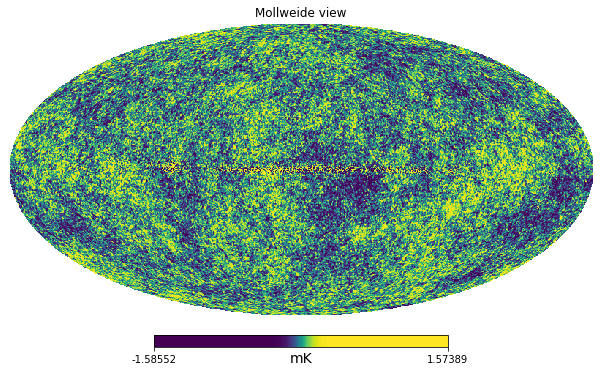

In [45]:
NSIDE = hp.get_nside(CMB_353_p)

CMB_map = output_map(alm_set, weights, LMAX, NSIDE)

hp.mollview((CMB_map * 10**3), unit='mK', norm='hist')


if synthetic==1:
    hp.write_map("ILC_synthetic_noise_05.fits", CMB_map, overwrite=True)

The next step is to work on assigning regions and working through them iteratively, as that improves the synchro (check) response.

Also must look into the FWHM value to use, whatever Sigma is just above and good choices for LMAX (https://healpix.sourceforge.io/html/fac_anafast.htm).

Sigma and FWHM refer to features of the gaussian beam that can be used to smooth the map.

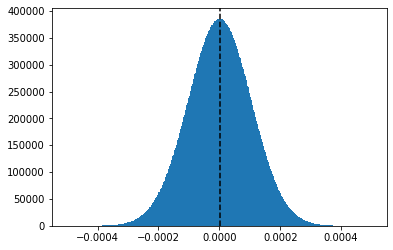

In [12]:
plt.hist(CMB_map, bins=500, range=(-0.0005,0.0005))
plt.axvline(CMB_map.mean(), color='k', linestyle='dashed')

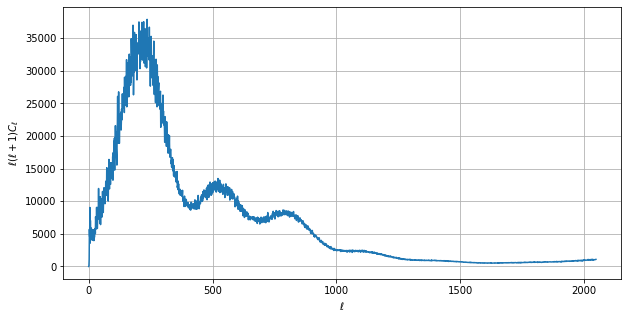

In [13]:
cl = hp.anafast((CMB_map), lmax=LMAX) * 10**12
ell = np.arange(len(cl))
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

In [14]:
common_mask = hp.read_map("COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits").astype(np.bool_)
print(common_mask)
def masking(input_map):
    
    masked      = hp.ma(input_map)
    masked.mask = np.logical_not(common_mask)
    output_map  = masked.filled()
    
    return output_map

/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
[ True  True  True ...  True  True  True]


In [15]:
CMB_30_p_masked = masking(CMB_30_p)
CMB_70_p_masked = masking(CMB_70_p)
CMB_143_p_masked = masking(CMB_143_p)
CMB_353_p_masked = masking(CMB_353_p)

CMB_30_h_masked  = harmonic(CMB_30_p_masked, LMAX)
CMB_70_h_masked  = harmonic(CMB_70_p_masked, LMAX)
CMB_143_h_masked = harmonic(CMB_143_p_masked, LMAX)
CMB_353_h_masked = harmonic(CMB_353_p_masked, LMAX)

alm_set_masked = (CMB_30_h_masked, CMB_70_h_masked, CMB_143_h_masked, CMB_353_h_masked)

In [16]:
x = cov_inv(alm_set_masked)
weights_masked = weight_gen(x)
print("The weights directly:",weights_masked)

The total weight is: (0.9999999999999998+4.440892098500626e-16j)
Small weighting error, probably negligible
The weights directly: [ 0.22229149+0.44910747j -2.02215859-3.44342738j  2.97881559+3.20093988j
 -0.1789485 -0.20661997j]


(4, 2100225)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify

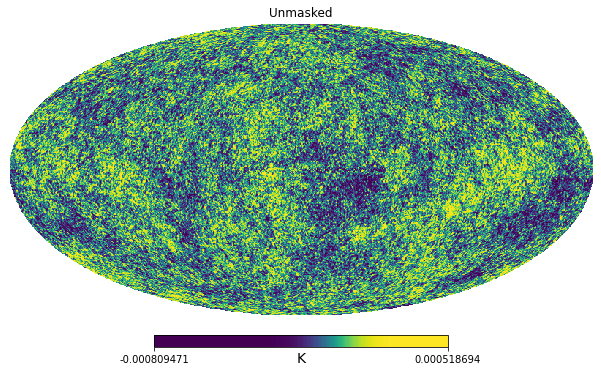

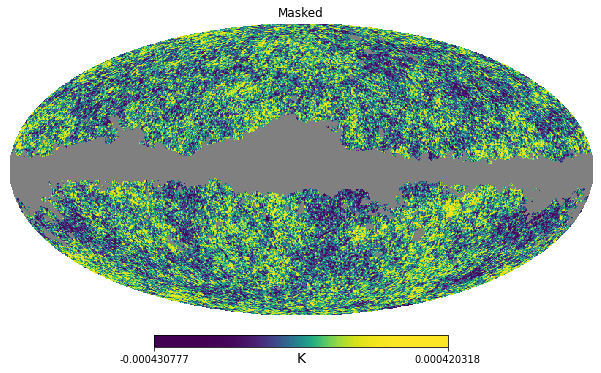

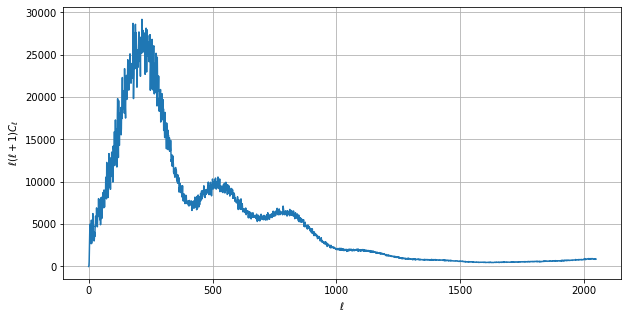

In [17]:
CMB_map_masked = masking(output_map(alm_set_masked, weights, LMAX, NSIDE))
#CMB_map_masked = masking(output_map(alm_set_masked, weights_masked, LMAX, NSIDE))
#hp.write_map("ILC_masked.fits", CMB_map_masked, overwrite=True)

hp.mollview(CMB_map, unit='K', norm='hist', title='Unmasked')
hp.mollview(CMB_map_masked,unit='K', norm='hist', title='Masked')

cl_masked = hp.anafast(CMB_map_masked, lmax=LMAX) * 10**12
ell = np.arange(len(cl))
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl_masked)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

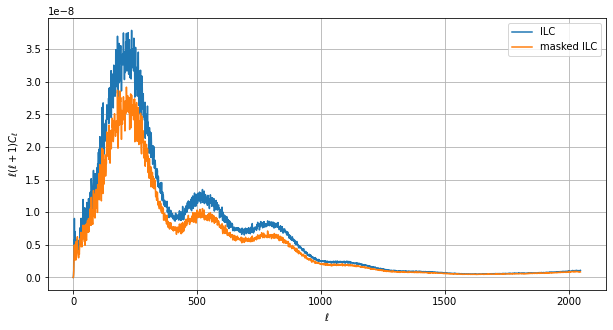

In [18]:
LMAX = 2048
cl = hp.anafast(CMB_map_masked, lmax=LMAX)
cl_ILC = hp.anafast((CMB_map), lmax=LMAX)
ell = np.arange(len(cl_ILC))

plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl_ILC, label="ILC")
plt.plot(ell, ell * (ell + 1) * cl, label="masked ILC")
plt.xlabel("$\ell$")
plt.legend()
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

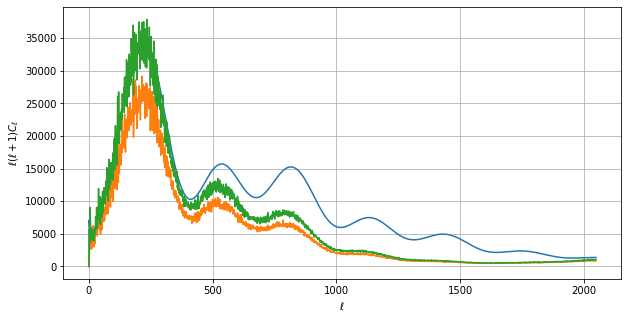

In [19]:
#'' Read in theoretical power spectrum from CAMB and renormalise '''
theorycls = [0.0]
theorycls.append(0.0)  
clsfile = open("CAMB_theory_cls.dat",'r')
data = clsfile.readlines()
for line in data :
    words = line.split()
    theorycls.append(float(words[1]))
clsfile.close()
theorycls = theorycls[0:LMAX+1]

for l in range(1, LMAX+1):
    theorycls[l] = theorycls[l]/float(l*(l+1))*2.*np.pi
    
#print(theorycls)
ell = np.arange(len(theorycls))

plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * theorycls)
plt.plot(ell, ell * (ell + 1) * cl * 10**12, label="masked ILC")
plt.plot(ell, ell * (ell + 1) * cl_ILC * 10**12, label="ILC")
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
#plt.xlim(0,1024)
plt.grid()

/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
The total weight is: (0.9999999999999998+4.440892098500626e-16j)
Small weighting error, probably negligible
The weights directly: [ 0.22229149+0.44910747j -2.02215859-3.44342738j  2.97881559+3.20093988j
 -0.1789485 -0.20661997j]
(4, 2100225)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify

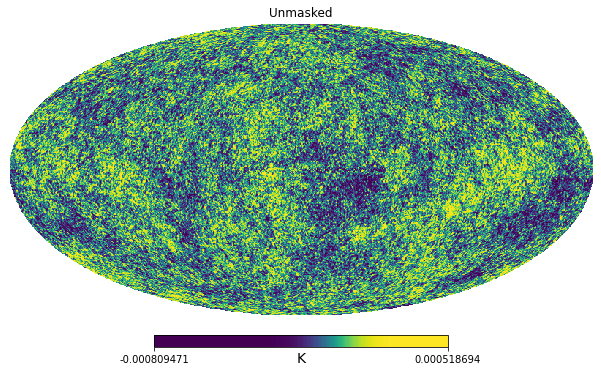

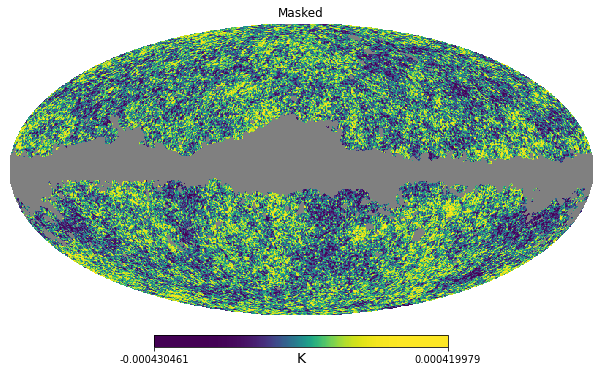

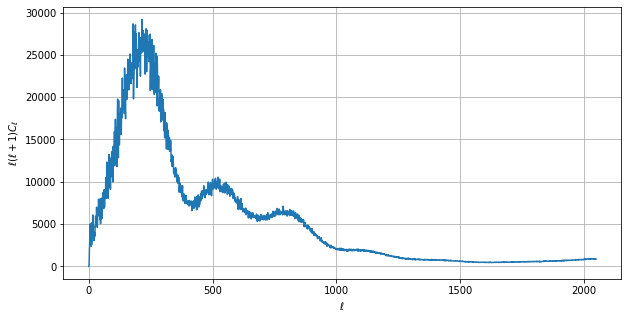

In [20]:
common_mask = hp.read_map("COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits").astype(np.bool_)

def masking(input_map):
    
    masked      = hp.ma(input_map)
    masked.mask = np.logical_not(common_mask)
    output_map  = masked.filled()
    
    return output_map

CMB_30_p_masked = masking(CMB_30_p)
CMB_70_p_masked = masking(CMB_70_p)
CMB_143_p_masked = masking(CMB_143_p)
CMB_353_p_masked = masking(CMB_353_p)

CMB_30_h_masked  = harmonic(CMB_30_p_masked, LMAX)
CMB_70_h_masked  = harmonic(CMB_70_p_masked, LMAX)
CMB_143_h_masked = harmonic(CMB_143_p_masked, LMAX)
CMB_353_h_masked = harmonic(CMB_353_p_masked, LMAX)

alm_set_masked = (CMB_30_h_masked, CMB_70_h_masked, CMB_143_h_masked, CMB_353_h_masked)

x = cov_inv(alm_set_masked)
weights_masked = weight_gen(x)
print("The weights directly:",weights_masked)

CMB_map_masked = masking(output_map(alm_set_masked, weights_masked, LMAX, NSIDE))
#CMB_map_masked = masking(output_map(alm_set_masked, weights_masked, LMAX, NSIDE))

hp.mollview(CMB_map, unit='K', norm='hist', title='Unmasked')
hp.mollview(CMB_map_masked,unit='K', norm='hist', title='Masked')

cl_masked = hp.anafast(CMB_map_masked, lmax=LMAX) * 10**12
ell = np.arange(len(cl))
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl_masked)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
The total weight is: (0.9999999999999996+0j)
Small weighting error, probably negligible
The weights directly: [ 0.34654607+0.24256427j -2.95042844-1.85448419j  3.84899378+1.72013443j
 -0.24511141-0.10821451j]
(4, 2100225)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/idies/miniconda3/lib/python3.6/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify

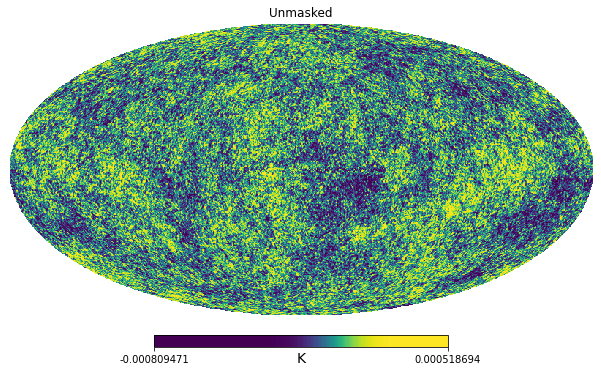

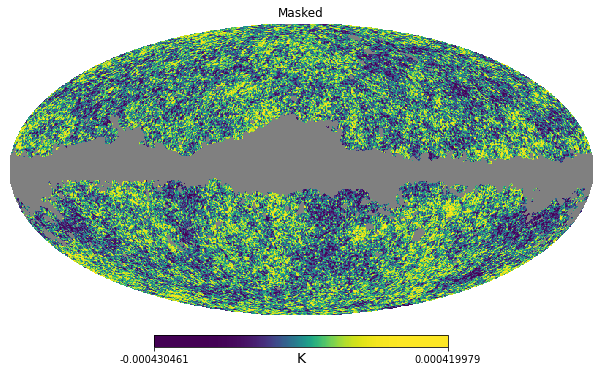

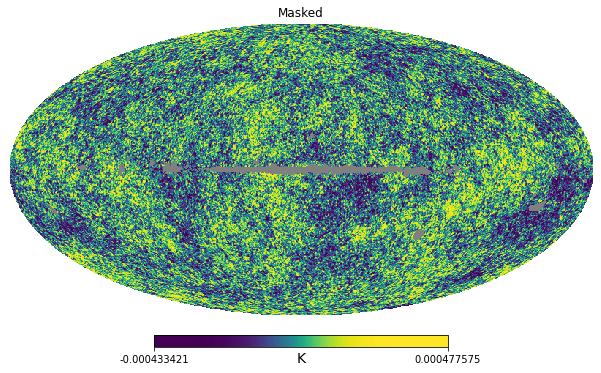

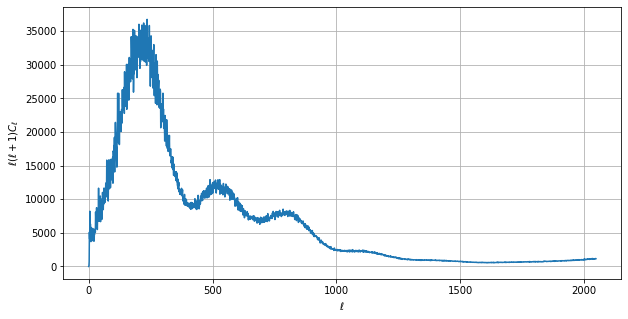

In [21]:
refined_mask = hp.read_map("COM_Mask_CMB-Inpainting-Mask-Int_2048_R3.00.fits").astype(np.bool_)

def masking(input_map):
    
    masked      = hp.ma(input_map)
    masked.mask = np.logical_not(refined_mask)
    output_map  = masked.filled()
    
    return output_map

CMB_30_p_masked = masking(CMB_30_p)
CMB_70_p_masked = masking(CMB_70_p)
CMB_143_p_masked = masking(CMB_143_p)
CMB_353_p_masked = masking(CMB_353_p)

CMB_30_h_masked  = harmonic(CMB_30_p_masked, LMAX)
CMB_70_h_masked  = harmonic(CMB_70_p_masked, LMAX)
CMB_143_h_masked = harmonic(CMB_143_p_masked, LMAX)
CMB_353_h_masked = harmonic(CMB_353_p_masked, LMAX)

alm_set_masked = (CMB_30_h_masked, CMB_70_h_masked, CMB_143_h_masked, CMB_353_h_masked)

x = cov_inv(alm_set_masked)
weights_masked = weight_gen(x)
print("The weights directly:",weights_masked)

CMB_map_masked_2 = masking(output_map(alm_set_masked, weights_masked, LMAX, NSIDE))
#CMB_map_masked = masking(output_map(alm_set_masked, weights_masked, LMAX, NSIDE))
#hp.write_map("ILC_masked.fits", CMB_map_masked, overwrite=True)

hp.mollview(CMB_map, unit='K', norm='hist', title='Unmasked')
hp.mollview(CMB_map_masked,unit='K', norm='hist', title='Masked')
hp.mollview(CMB_map_masked_2,unit='K', norm='hist', title='Masked')

cl_masked_2 = hp.anafast(CMB_map_masked_2, lmax=LMAX) * 10**12
ell = np.arange(len(cl))
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl_masked_2)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

In [22]:
#hp.write_map("ILC_refined_masked.fits", CMB_map_masked_2, overwrite=True)
#hp.write_map("ILC_masked.fits", CMB_map_masked, overwrite=True)

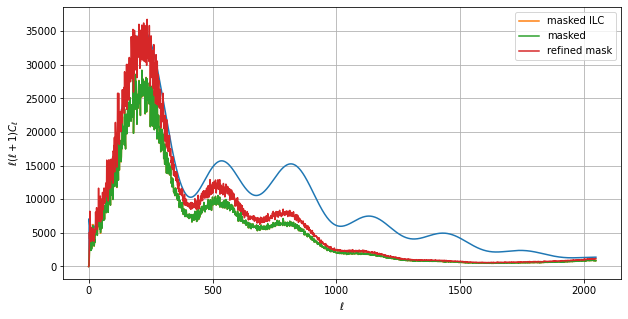

In [23]:
#'' Read in theoretical power spectrum from CAMB and renormalise '''
theorycls = [0.0]
theorycls.append(0.0)  
clsfile = open("CAMB_theory_cls.dat",'r')
data = clsfile.readlines()
for line in data :
    words = line.split()
    theorycls.append(float(words[1]))
clsfile.close()
theorycls = theorycls[0:LMAX+1]

for l in range(1, LMAX+1):
    theorycls[l] = theorycls[l]/float(l*(l+1))*2.*np.pi
    
#print(theorycls)
ell = np.arange(len(theorycls))

plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * theorycls)
plt.plot(ell, ell * (ell + 1) * cl * 10**12, label="masked ILC")
plt.plot(ell, ell * (ell + 1) * cl_masked , label="masked")
plt.plot(ell, ell * (ell + 1) * cl_masked_2, label="refined mask")
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.legend()
#plt.xlim(0,1024)
plt.grid()